In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("input/train_indessa.csv")

## Preprocessing

In [3]:
data = data.fillna("0")

In [4]:
data['last_week_pay'] = data['last_week_pay'].str.extract('(\d+)', expand=False)
data = data.fillna("0")
data['last_week_pay'] = data['last_week_pay'].astype(int)

In [5]:
data['term'] = data['term'].str.extract('(\d+)', expand=False).astype(int)
data = data.fillna("0")
data['term'] = data['term'].astype(int)

In [6]:
# Extract a new feature from term and last week pay

data.insert(0, 'payment_completion', (data['last_week_pay']/(data['term']/12*52+1))*100)
data['payment_completion'] = data['payment_completion'].astype(int)

In [7]:
# Extract a new feature from funded_amnt_inv / loan_amnt

data.insert(0, 'funded_ratio', (data['funded_amnt_inv']/data['loan_amnt'])*100)
data['funded_ratio'] = data['funded_ratio'].astype(int)

In [8]:
# Drop irrelevant features and text features
drop_cols = ['member_id', 'batch_enrolled', 'desc', 'title', 'emp_title']
data.drop(drop_cols, 1, inplace=True)

In [9]:
# Encode Label for Classifier
from sklearn.preprocessing import LabelEncoder

cat_cols = ['grade', 'sub_grade', 'emp_length', 'home_ownership', 'verification_status', 
            'pymnt_plan', 'purpose', 'initial_list_status', 'application_type', 
            'verification_status_joint', 'zip_code', 'addr_state']
le = {}

for col in cat_cols:
    le[col] = LabelEncoder()
    data[col] = le[col].fit_transform(data[col])
    le[col].classes_ = np.append(le[col].classes_, 'other')
    
    print('Encoded: ', col)

Encoded:  grade
Encoded:  sub_grade
Encoded:  emp_length
Encoded:  home_ownership
Encoded:  verification_status
Encoded:  pymnt_plan
Encoded:  purpose
Encoded:  initial_list_status
Encoded:  application_type
Encoded:  verification_status_joint
Encoded:  zip_code
Encoded:  addr_state


## Split Training Set

In [10]:
split = int(len(data)*0.75)

# four most important features, performance score = 0.8685
major = ['tot_cur_bal', 'last_week_pay', 'total_rev_hi_lim', 'int_rate']

# not so important features, performance score = 0.7634
minor = ['tot_cur_bal','zip_code', 'addr_state', 'revol_util', 'revol_bal', 'sub_grade', 'annual_inc', 'total_rec_int']

data = data.dropna()
X_train = data[data['loan_status'] >= 0].iloc[:split,:-1]
Y_train = data[data['loan_status'] >= 0].iloc[:split,-1:]
X_test = data[data['loan_status'] >= 0].iloc[split:,:-1]
Y_test = data[data['loan_status'] >= 0].iloc[split:,-1:]

## Ensembled Model #1: Random Forest Classifier

In [11]:
from sklearn.ensemble import RandomForestClassifier

In [12]:
rf = RandomForestClassifier(n_estimators=100, verbose=5, n_jobs=-1)
rf.fit(X_train, Y_train)

/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/ipykernel/__main__.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


building tree 2 of 100building tree 3 of 100building tree 4 of 100building tree 5 of 100building tree 6 of 100building tree 7 of 100building tree 8 of 100building tree 9 of 100building tree 10 of 100building tree 11 of 100building tree 12 of 100building tree 13 of 100building tree 14 of 100building tree 15 of 100building tree 16 of 100building tree 1 of 100building tree 17 of 100building tree 20 of 100building tree 21 of 100building tree 23 of 100building tree 26 of 100building tree 27 of 100building tree 28 of 100building tree 29 of 100building tree 24 of 100building tree 30 of 100building tree 31 of 100building tree 32 of 100building tree 33 of 100building tree 22 of 100building tree 19 of 100building tree 34 of 100building tree 35 of 100building tree 18 of 100building tree 25 of 100building tree 36 of 100



































building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
b

[Parallel(n_jobs=-1)]: Done  50 out of 100 | elapsed:    6.5s remaining:    6.5s


building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100
building tree 94 of 100
building tree 95 of 100
building tree 97 of 100building tree 96 of 100

building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=-1)]: Done  71 out of 100 | elapsed:    7.9s remaining:    3.2s
[Parallel(n_jobs=-1)]: Done  92 out of 100 | elapsed:    9.1s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    9.8s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=-1, oob_score=False,
            random_state=None, verbose=5, warm_start=False)

In [13]:
rf.score(X_test, Y_test)

[Parallel(n_jobs=36)]: Done  50 out of 100 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=36)]: Done  71 out of 100 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=36)]: Done  92 out of 100 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=36)]: Done 100 out of 100 | elapsed:    0.4s finished


0.86026279609637357

## Ensembled Model #2: KNeighbors Classifier

In [14]:
from sklearn.neighbors import KNeighborsClassifier

In [15]:
from sklearn.model_selection import validation_curve

knc_train_scores, knc_valid_scores = validation_curve(KNeighborsClassifier(), X_train, Y_train.values.reshape(-1), 
                                             'n_neighbors', np.arange(5,50,5), n_jobs=-1, verbose=2)

[CV] n_neighbors=5 ...................................................
[CV] n_neighbors=10 ..................................................
[CV] n_neighbors=15 ..................................................
[CV] n_neighbors=20 ..................................................
[CV] n_neighbors=25 ..................................................
[CV] n_neighbors=30 ..................................................
[CV] n_neighbors=35 ..................................................
[CV] n_neighbors=40 ..................................................
[CV] n_neighbors=45 ..................................................
[CV] n_neighbors=5 ...................................................
[CV] n_neighbors=10 ..................................................
[CV] n_neighbors=15 ..................................................
[CV] n_neighbors=20 ..................................................
[CV] n_neighbors=25 ..................................................
[CV] n

[Parallel(n_jobs=-1)]: Done  14 out of  27 | elapsed:  3.1min remaining:  2.9min


[CV] ......................................... n_neighbors=25 - 1.0min
[CV] ......................................... n_neighbors=30 - 1.2min
[CV] ......................................... n_neighbors=35 - 1.2min
[CV] ......................................... n_neighbors=35 - 1.3min
[CV] ......................................... n_neighbors=30 - 1.2min
[CV] ......................................... n_neighbors=30 - 1.2min
[CV] ......................................... n_neighbors=35 - 1.2min
[CV] ......................................... n_neighbors=40 - 1.3min
[CV] ......................................... n_neighbors=40 - 1.3min
[CV] ......................................... n_neighbors=40 - 1.4min
[CV] ......................................... n_neighbors=45 - 1.4min
[CV] ......................................... n_neighbors=45 - 1.5min
[CV] ......................................... n_neighbors=45 - 1.5min


[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:  4.0min finished


In [18]:
knc_train_scores_mean = np.mean(knc_train_scores, axis=1)
knc_train_scores_std = np.std(knc_train_scores, axis=1)
knc_valid_scores_mean = np.mean(knc_valid_scores, axis=1)
knc_valid_scores_std = np.std(knc_valid_scores, axis=1)
knc_param_range = np.arange(5,50,5)

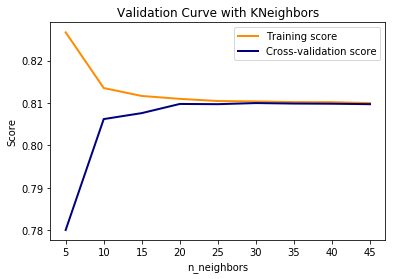

In [19]:
plt.title("Validation Curve with KNeighbors")
plt.xlabel("n_neighbors")
plt.ylabel("Score")
lw=2
plt.plot(knc_param_range, knc_train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.plot(knc_param_range, knc_valid_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.legend(loc="best")
plt.show()
plt.show()

In [27]:
knc = KNeighborsClassifier(n_neighbors=20, n_jobs=-1)
knc.fit(X_train, Y_train)

/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/ipykernel/__main__.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  from ipykernel import kernelapp as app


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=20, p=2,
           weights='uniform')

In [28]:
knc.score(X_test, Y_test)

0.80946156099979716

## Ensembled Model #3: SGD Classifier

In [29]:
from sklearn.linear_model import SGDClassifier

In [32]:
sgd = SGDClassifier(loss='modified_huber', verbose=2, n_jobs=-1, n_iter=1000)
sgd.fit(X_train, Y_train)

/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


-- Epoch 1
Norm: 420030.03, NNZs: 41, Bias: 1796.540696, T: 399321, Avg. loss: 20098213156.617496
Total training time: 0.10 seconds.
-- Epoch 2
Norm: 326072.64, NNZs: 41, Bias: 1924.722210, T: 798642, Avg. loss: 11224096613.713718
Total training time: 0.19 seconds.
-- Epoch 3
Norm: 284447.47, NNZs: 41, Bias: 2000.133575, T: 1197963, Avg. loss: 7952962235.659480
Total training time: 0.27 seconds.
-- Epoch 4
Norm: 253337.25, NNZs: 41, Bias: 2039.081081, T: 1597284, Avg. loss: 6205310374.044536
Total training time: 0.36 seconds.
-- Epoch 5
Norm: 234806.99, NNZs: 41, Bias: 2074.909855, T: 1996605, Avg. loss: 5119816311.888704
Total training time: 0.44 seconds.
-- Epoch 6
Norm: 220701.20, NNZs: 41, Bias: 2094.273710, T: 2395926, Avg. loss: 4373445938.996845
Total training time: 0.53 seconds.
-- Epoch 7
Norm: 209305.85, NNZs: 41, Bias: 2114.445202, T: 2795247, Avg. loss: 3826330578.150474
Total training time: 0.62 seconds.
-- Epoch 8
Norm: 199206.58, NNZs: 41, Bias: 2125.434492, T: 3194568, 

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='modified_huber', n_iter=1000,
       n_jobs=-1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, verbose=2, warm_start=False)

In [33]:
sgd.score(X_test, Y_test)

0.79173146416041229

## Emsemble Model with RF

In [60]:
pred_train_rf = rf.predict(X_train)
pred_train_knc = knc.predict(X_train)
pred_train_sgd = sgd.predict(X_train)

[Parallel(n_jobs=36)]: Done  50 out of 100 | elapsed:    0.8s remaining:    0.8s
[Parallel(n_jobs=36)]: Done  71 out of 100 | elapsed:    0.9s remaining:    0.4s
[Parallel(n_jobs=36)]: Done  92 out of 100 | elapsed:    1.1s remaining:    0.1s
[Parallel(n_jobs=36)]: Done 100 out of 100 | elapsed:    1.2s finished


In [61]:
prediction_train = pd.DataFrame({
    'rf': pred_train_rf,
    'knc': pred_train_knc,
    'sgd': pred_train_sgd
})

In [62]:
ensemble = RandomForestClassifier(n_estimators=100, verbose=5, n_jobs=-1)
ensemble.fit(prediction_train, Y_train)

/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/ipykernel/__main__.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


building tree 1 of 100
building tree 2 of 100building tree 3 of 100building tree 4 of 100building tree 5 of 100building tree 6 of 100building tree 7 of 100building tree 8 of 100building tree 10 of 100building tree 11 of 100building tree 12 of 100building tree 14 of 100building tree 15 of 100building tree 16 of 100building tree 18 of 100building tree 13 of 100building tree 19 of 100building tree 20 of 100building tree 21 of 100building tree 22 of 100building tree 17 of 100building tree 23 of 100building tree 24 of 100building tree 9 of 100building tree 25 of 100building tree 26 of 100building tree 27 of 100building tree 28 of 100building tree 29 of 100building tree 30 of 100building tree 31 of 100building tree 32 of 100building tree 33 of 100building tree 34 of 100building tree 35 of 100building tree 36 of 100


































building tree 37 of 100
building tree 38 of 100
building tree 39 of 100building tree 40 of 100building tree 41 of 100building tree 42 of 100build

[Parallel(n_jobs=-1)]: Done  50 out of 100 | elapsed:    0.6s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  71 out of 100 | elapsed:    0.8s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  92 out of 100 | elapsed:    0.9s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.0s finished


building tree 70 of 100building tree 71 of 100building tree 73 of 100building tree 72 of 100














building tree 74 of 100building tree 75 of 100building tree 76 of 100building tree 78 of 100building tree 79 of 100building tree 81 of 100building tree 88 of 100building tree 83 of 100building tree 91 of 100building tree 99 of 100

building tree 82 of 100building tree 100 of 100building tree 94 of 100building tree 85 of 100


building tree 80 of 100building tree 77 of 100building tree 90 of 100building tree 92 of 100building tree 95 of 100building tree 84 of 100building tree 96 of 100building tree 97 of 100building tree 93 of 100building tree 86 of 100building tree 87 of 100building tree 98 of 100
building tree 89 of 100


























RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=-1, oob_score=False,
            random_state=None, verbose=5, warm_start=False)

In [63]:
pred_test_rf = rf.predict(X_test)
pred_test_knc = knc.predict(X_test)
pred_test_sgd = sgd.predict(X_test)

[Parallel(n_jobs=36)]: Done  50 out of 100 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=36)]: Done  71 out of 100 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=36)]: Done  92 out of 100 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=36)]: Done 100 out of 100 | elapsed:    0.5s finished


In [64]:
prediction_test = pd.DataFrame({
    'rf': pred_test_rf,
    'knc': pred_test_knc,
    'sgd': pred_test_sgd
})

In [65]:
ensemble.score(prediction_test, Y_test)

[Parallel(n_jobs=36)]: Done  50 out of 100 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=36)]: Done  71 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=36)]: Done  92 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=36)]: Done 100 out of 100 | elapsed:    0.1s finished


0.86026279609637357

In [66]:
fi = list(zip(prediction_test.columns.values, ensemble.feature_importances_))
fi = sorted(fi, key=lambda x: -x[1])
pd.DataFrame(fi, columns=["Feature","Importance"])

,Feature,Importance
0,rf,0.905543
1,knc,0.063978
2,sgd,0.030479


**Observation**:  Performance is occupied by the best model. Does not increase.